# 02 - Seismic imaging: Reverse Time Migration

This notebook is the second in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this second example we aim to highlight the core ideas behind seismic inversion, where we create an image of the subsurface from field recorded data. This tutorial follows on the modelling tutorial and will reuse the modelling and velocity model.

## Imaging requirement

Seismic imaging relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is aquired as described in the first tutorial. In order to simplify this tutorial we will generate synthetic field data by modelling it with the **true velocity model**.

- **Background velocity model**. This is a velocity model that has been obtained by processing and inverting the field data. We will look at this methods in the following tutorial as it relies on the method we are describing here. This velocity model is usually a **smooth version** of the true velocity model.

## Imaging computational setup

In this tutorial, we will introduce the back-propagation operator. This operator simulates the adjoint wave-equation, that is a wave-equation solved in a reversed time order. This time reversal led to the naming of the method we present here called Reverse Time Migration. The notion of adjoint in exploration geophysics is fundamental as most of the wave-equation based imaging and inversion methods rely on adjoint based optimization methods.

## Notes on the operators

As we already describe the creation of a forward modelling operator, we will use a thin wrapper function instead. This wrapper is provided by a utility class called `AcousticWaveSolver`, which provides all the necessary operators for seismic modeling, imaging and inversion. The `AcousticWaveSolver` provides a more concise API for common wave propagation operators and caches the the Devito `Operator` objects to avoid unnecessary recompilation. However, any newly introduced operators will be fully described and only used from the wrapper in the next tutorials.

As before we initialise printing and import some utilities. We also raise the Devito log level to avoid excessive logging for repeated operator invocations.

In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log_level'] = 'WARNING'

## Computational considerations

Seismic inversion algorithms are generally very computationally demanding and require a large amount of memory to store the forward wavefield. In order to keep this tutorial as light-weight as possible we are using a very trivial
velocity model that requires low temporal and special resolution. For a more realistic model a second set of preset parameters is provided below in comments that can be run to create some more detailed images. However, this second present is a bit more computationally demanding and requires a slightly more powerful workstation.

In [2]:
from examples.seismic import demo_model

# Enable model presets here:
preset = 'twolayer'  # A simple but cheap model (recommended)
# preset = 'marmousi2d'  # A larger more realistic model

# Standard preset with a simple two-layer model
if preset == 'twolayer':
    def create_model():
        return demo_model('twolayer', origin=(0., 0.), shape=(101, 101),
                          spacing=(10., 10.), nbpml=20)
    filter_sigma = (1, 1)
    nsources = 21
    nreceivers = 101
    t0 = 0.
    tn = 1000.  # Simulation last 1 second (1000 ms)
    f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)


# A more computationally demanding preset based on the 2D Marmousi model

if preset == 'marmousi2d':
    def create_model():
        return demo_model('marmousi2d', data_path='../../../../opesci-data/')
    filter_sigma = (6, 6)
    nsources = 20
    nreceivers = 601
    t0 = 0.
    tn = 2500.  # Simulation last 1 second (2500 ms)
    f0 = 0.025  # Source peak frequency is 25Hz (0.025 kHz)

# True and smooth velocity models

First, we create the model data for the "true" model from a given demonstration preset. We will
later use this model to generate our synthetic data readings. We will then also generate a second
model and apply a smoothing filter to it, which represents our initial model for the imaging algorithm.
The perturbation between these two models can be thought of as the image we are trying to recover.

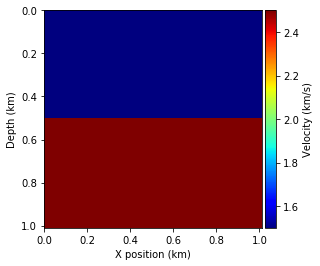

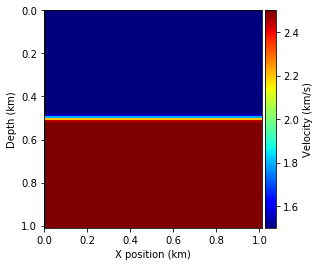

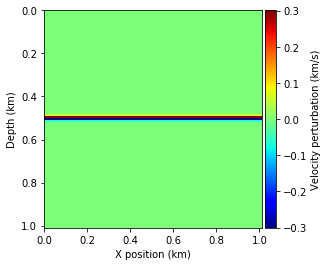

In [3]:
from examples.seismic import plot_velocity, plot_perturbation
from scipy import ndimage

# Create true model from a preset
model = create_model()

# Create initial model and smooth the boundaries
model0 = create_model()
model0.vp = ndimage.gaussian_filter(model0.vp, sigma=filter_sigma, order=0)

# Plot the true and initial model and the perturbation between them
plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

# True and smooth data

We can now generate the shot record correspondingto both models. The difference between this two record will be the basis of the imaging procedure. The acquisition geometry is the same as in the previous tutorial.

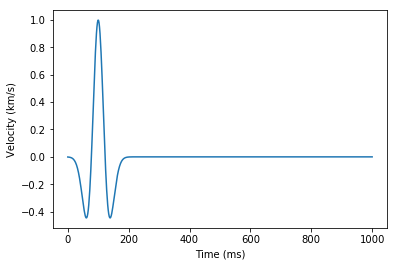

In [4]:
from examples.seismic import RickerSource

# Define time discretization according to grid spacing
dt = model.critical_dt  # Time step from model grid spacing
nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time

src = RickerSource(name='src', ndim=2, f0=f0, time=np.linspace(t0, tn, nt))

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

In [5]:
from examples.seismic import Receiver
# Receiver initialization. This one does not contain any
# data as it will be computed during the simulation and correspond
# to the true model
true_d = Receiver(name='rec', npoint=nreceivers, ntime=nt, ndim=2)
true_d.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
true_d.coordinates.data[:, 1] = 30.

# Receiver initialization. This one does not contain any
# data as it will be computed during the simulation and correspond
# to the smooth model
smooth_d = Receiver(name='rec', npoint=nreceivers, ntime=nt, ndim=2)
smooth_d.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
smooth_d.coordinates.data[:, 1] = 30.

In [6]:
# Forward operator 
from examples.seismic.acoustic import AcousticWaveSolver
from devito.interfaces import TimeData

solver = AcousticWaveSolver(model, src, true_d, space_order=4)
true_d , _, _ = solver.forward(src=src, rec=true_d, m=model.m)

In [7]:
# Smooth data
smooth_d, _, _ = solver.forward(src=src, rec=smooth_d, m=model0.m)

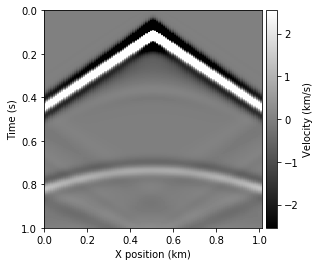

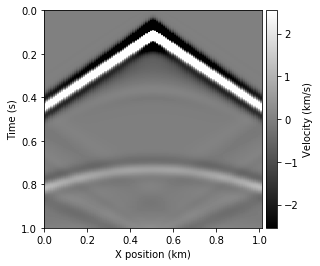

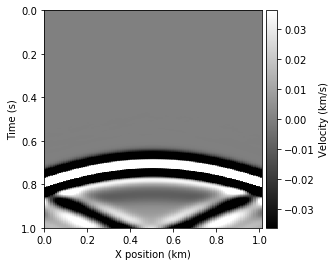

In [8]:
from examples.seismic import plot_shotrecord

# Shot record for the true and smooth velocity model and the difference
plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

The only difference between the smooth and the true velocity model is the value of the velocity. The dimensions of the model are unchanged. We can therefore reuse the forward modelling operator we just build and only specify the new velocity model, the shot record we want the result to be in and a new initialized wavefield.

If the shot record is not specified, the data will still be computed but will overwrite the true shot record. Concerning the initialization of a new wavefield, this comes from the simplified interface of this tutorial. In practice, a warapper would be built around the operator to reinitialize any field at runtime.

# Imaging with backpropagation

As we explained in the introduction of this tutorial, this method is based on backprobagation. 

## Adjoint wave equation

If we go back to the modelling part, we can rewrite the simulation as a linear system solve:

\begin{equation}
\mathbf{A}(\mathbf{m}) \mathbf{u} = \mathbf{q}
\end{equation}

where $\mathbf{m}$ is the discretized square slowness, $\mathbf{q}$ is the discretized source and $\mathbf{A}(mathbf{m})$ is the discretized wave-equation. The discretized wave-equation matricial representation is a lower triangular matrix that can be solve with forward subsitution. The pointwise writing ot the forward substitution leads to the time-stepping stencil.

On a small problem, and with a linear algebra software such as Matlab, one could form the matrix explicitly and transpose it to obtain the adjoint discrete wave-equation:

\begin{equation}
\mathbf{A}(\mathbf{m})^T \mathbf{v} = \delta \mathbf{d}
\end{equation}

where $\mathbf{v}$ is the discrete **adjoint wavefield** and  $\delta \mathbf{d}$ is the data residual defined as the difference between the field/observed data and the synthetic data $\mathbf{d}_s = \mathbf{P}_r \mathbf{u}$. In our case we derive the discrete adjoint wave-equation from the diiscfete forward wave-equation to get its stencil. 

## Imaging

Wave-equation based imaging relies on one simple concept.

- If the background velocity model is cinematically coorect, the forward wavefield $\mathbf{u}$ and the adjoint wavefield $\mathbf{v}$ meet at the reflectors position at zero time offset. 

The summ over time of the zero time-offset coorelation of this two fields creates then an image of the subsurface. Mathematically this eads to the simple imaging condition:

\begin{equation}
  \text{Image} = \sum_{t=1}^{n_t} \mathbf{u}[t] \mathbf{v}[t]
\end{equation}

We will describe in following tutorials more advanced imaging condition tha produces shaper/ more accurate results.

## Computational considerations

As we just explaine, the forward wave-equation is solved forward in time while the adjoint wave-equation is solved in a reversed time order. Therefor, the correlation of this two field over time requires to store one of the two fields. The computational workflow for imaging follows:

- Simulate the forward wave-equation with the background veocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the Image contribution at each time step. 

This workflo is applied to multiple source position and sumed to obatain the full image of the subsurface.

In [9]:
from devito import Backward, Operator
from devito import t, time, x, y
from examples.seismic import PointSource

from sympy import solve, Eq


def image(model, image):
    # Define the wavefield with the size of the model and the time dimension
    v = TimeData(name='vg', shape=model.shape_domain, time_order=2, space_order=4)

    u = TimeData(name='ug', shape=model.shape_domain, time_order=2, space_order=4,
                 save=True, time_dim=nt)
    # We can now write the PDE
    pde = model.m * v.dt2 - v.laplace - model.damp * v.dt

    # This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
    # Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as
    # a time marching updating equation known as a stencil using sympy functions
    stencil = Eq(v.backward, solve(pde, v.backward)[0])
    
    # Finally we define the source injection and receiver read function to generate the corresponding code
    residual = PointSource(name='residual', npoint=nreceivers, ntime=nt, ndim=2)
    residual.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
    residual.coordinates.data[:, 1] = 30.
    
    res_term = residual.inject(field=v, expr=residual * model.critical_dt ** 2 / model.m,
                               offset=model.nbpml)
    # Correlate the forward and adjoint wavefield for the current time step and add it to the image
    image_update = Eq(image, image - u * v)

    op = Operator([stencil] + res_term + [image_update],
                  subs={t.spacing: model.critical_dt, x.spacing: model.spacing[0],
                        y.spacing: model.spacing[1]},
                  time_axis=Backward)
    # Force compile the operator for simple reuse and correctness of the time axis
    return op

In [10]:
from devito.interfaces import DenseData

# Gradient operator
Im = DenseData(name='Im', shape=model.shape_domain, dtype=model.m.dtype)
Imaging = image(model, Im)

# Prepare the varying source locations sources
sources = np.linspace(0, 1000, num=nsources)

for i, location in enumerate(sources):
    print('Imaging source %d out of %d' % (i+1, nsources))
    
    # Update source location
    src.coordinates.data[0, 0] = location
    src.coordinates.data[0, 1] = 30.

    # Generate synthetic data from true model
    solver.forward(src=src, rec=true_d, m=model.m)
    
    # Compute smooth data and full forward wavefield u0
    smooth_d, u0, _ = solver.forward(src=src, rec=smooth_d, m=model0.m, save=True)
    
    # Compute gradient from the data residual  
    v = TimeData(name='v', shape=model.shape_domain, time_order=2, space_order=4)
    Imaging(ug=u0, vg=v, m=model0.m, residual=smooth_d.data - true_d.data)

Imaging source 1 out of 21
Imaging source 2 out of 21
Imaging source 3 out of 21
Imaging source 4 out of 21
Imaging source 5 out of 21
Imaging source 6 out of 21
Imaging source 7 out of 21
Imaging source 8 out of 21
Imaging source 9 out of 21
Imaging source 10 out of 21
Imaging source 11 out of 21
Imaging source 12 out of 21
Imaging source 13 out of 21
Imaging source 14 out of 21
Imaging source 15 out of 21
Imaging source 16 out of 21
Imaging source 17 out of 21
Imaging source 18 out of 21
Imaging source 19 out of 21
Imaging source 20 out of 21
Imaging source 21 out of 21


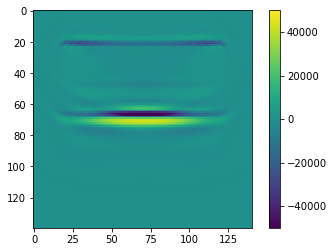

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plot = plt.imshow(np.diff(np.transpose(Im.data[:, :]), axis=0), vmin=-5e4, vmax=5e4)
cbar = plt.colorbar(plot)
plt.show()

And we have an image of the subsurface with a strong reflector at the original location.